<a href="https://colab.research.google.com/github/bb20417/CE888/blob/main/Lab8/TFLearn_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/sagihaider/CE888_2021/main/Lab_8/data.zip
!unzip data.zip

--2021-05-03 21:45:52--  https://raw.githubusercontent.com/sagihaider/CE888_2021/main/Lab_8/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20194537 (19M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  19.26M  42.5MB/s    in 0.5s    

2021-05-03 21:45:53 (42.5 MB/s) - ‘data.zip’ saved [20194537/20194537]

Archive:  data.zip
   creating: data/
   creating: data/cats/
  inflating: data/cats/cat.1.jpg     
  inflating: data/cats/cat.10.jpg    
  inflating: data/cats/cat.100.jpg   
  inflating: data/cats/cat.101.jpg   
  inflating: data/cats/cat.102.jpg   
  inflating: data/cats/cat.103.jpg   
  inflating: data/cats/cat.104.jpg   
  inflating: data/cats/cat.105.jpg   
  inflating: data/cats/cat.106.jpg   
  infl

In [2]:
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
image_generator = ImageDataGenerator(rescale=1.0/255, 
                               rotation_range=20,
                               horizontal_flip=True, 
                               validation_split=0.1)

In [4]:
train_data = image_generator.flow_from_directory('./data/', target_size=(304,329),
                                      batch_size=4,subset='training')

val_data = image_generator.flow_from_directory('./data/', target_size=(304,329),
                                      batch_size=4,subset='validation')

Found 728 images belonging to 4 classes.
Found 80 images belonging to 4 classes.


In [5]:
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras import Model

image_size = [304,329,3]

In [6]:
input = Input(shape = image_size)
model = Xception(input_tensor=input,)

91889664/91884032 [==============================] - 1s 0us/step


In [7]:
model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304, 329, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 151, 164, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 151, 164, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 151, 164, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [8]:
last_layer = model.get_layer('block14_sepconv2_act').output
x= Flatten(name='flatten')(last_layer)
x = Dense(128, activation='relu', name='fc1')(x)
x = Dense(64, activation='relu', name='fc2')(x)
out = Dense(4, activation='softmax', name='output')(x)
model = Model(input, out)

for layer in model.layers[:-3]:
	layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 304, 329, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 151, 164, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 151, 164, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 151, 164, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics="accuracy")
my_callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=10, restore_best_weights=True),
    ModelCheckpoint(filepath='xception_model.h5', save_best_only=True),
]

model.fit(train_data, validation_data=val_data, epochs=50, callbacks=my_callbacks)

Epoch 1/50
182/182 [==============================] - 56s 119ms/step - loss: 2.6366 - accuracy: 0.8434 - val_loss: 0.4688 - val_accuracy: 0.9750
Epoch 2/50
182/182 [==============================] - 21s 114ms/step - loss: 1.0239 - accuracy: 0.9616 - val_loss: 1.9664e-05 - val_accuracy: 1.0000
Epoch 3/50
182/182 [==============================] - 21s 114ms/step - loss: 0.8657 - accuracy: 0.9591 - val_loss: 0.0064 - val_accuracy: 1.0000
Epoch 4/50
182/182 [==============================] - 21s 114ms/step - loss: 0.7646 - accuracy: 0.9818 - val_loss: 2.6822e-08 - val_accuracy: 1.0000
Epoch 5/50
182/182 [==============================] - 21s 114ms/step - loss: 0.1503 - accuracy: 0.9902 - val_loss: 0.1043 - val_accuracy: 0.9875
Epoch 6/50
182/182 [==============================] - 21s 113ms/step - loss: 0.1919 - accuracy: 0.9854 - val_loss: 4.5103e-04 - val_accuracy: 1.0000
Epoch 7/50
182/182 [==============================] - 21s 113ms/step - loss: 0.1259 - accuracy: 0.9903 - val_loss: 1.1

In [10]:
history = pd.DataFrame(model.history.history)
history.head()

,loss,accuracy,val_loss,val_accuracy
0,2.128465,0.894231,4.687735e-01,0.9750
1,1.074483,0.960165,1.966449e-05,1.0000
2,0.932118,0.956044,6.405742e-03,1.0000
3,0.561475,0.980769,2.682206e-08,1.0000
4,0.244817,0.990385,1.042983e-01,0.9875


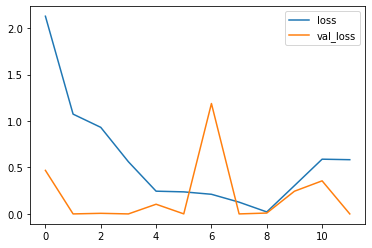

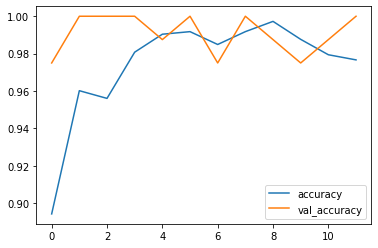

In [11]:
history[['loss', 'val_loss']].plot()
history[['accuracy','val_accuracy']].plot()